<a href="https://colab.research.google.com/github/duonghung86/GAN-Generative-Adversarial-Networks/blob/main/TF_VanillaGAN_UD3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla GAN for Uniform Distribution
---
$$ X = 
\left(\begin{array}{cc} 
- & X_1 & -\\
... & ... & ...\\
- & X_i & -\\
... & ... & ...\\
- & X_n & -\\
\end{array}\right)
$$

$X_i \sim U(0,1)$ for $i=1,m$

Reference: 
- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
- https://www.tensorflow.org/tutorials/generative/dcgan


## Setup

In [1]:
# Load packages
import numpy as np
import seaborn as sns
import os
from scipy.stats import moment
import time
# Tensorflow
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

# Visualization
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython import display

# Download output files
from google.colab import files

2.4.1


## Load and prepare the dataset

Data set have shape $n \times m$:
- $X_i$ is a U(0,1) random variable for $i$ in $[1,n]$

In [2]:
# True data distribution
B = 1
A = 0
# data set shape
N = 1000
M = 1000
np.random.seed(423)
X = np.random.uniform(B,A,size = (N,M))

[306 502 903 939]


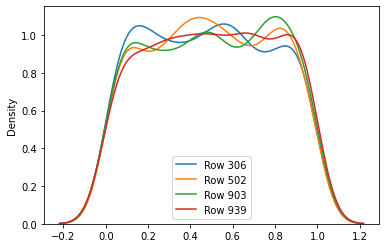

In [3]:
# Visualization
ind = np.random.randint(N,size=4)
print(ind)
for i in ind:
    sns.kdeplot(X[i,:],label = 'Row {}'.format(i))
plt.legend()
plt.show()

In [4]:
BUFFER_SIZE = N
BATCH_SIZE = 32
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses full connected layers to produce a distribution from a seed (random noise). 

In [5]:
def make_generator_model(in_dim = 100, out_dim = 1):
    model = Sequential()
    model.add(Dense(20, activation='relu', kernel_initializer='he_uniform', input_dim=in_dim))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(out_dim, activation='tanh'))

    #model.add(layers.Dense(20, use_bias=False, input_shape=(100,)))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dense(COL))
    #model.add(layers.LeakyReLU())
    return model

Use the (as yet untrained) generator to create a distribution.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              21000     
Total params: 23,440
Trainable params: 23,440
Non-trainable params: 0
_________________________________________________________________
(3, 1000)


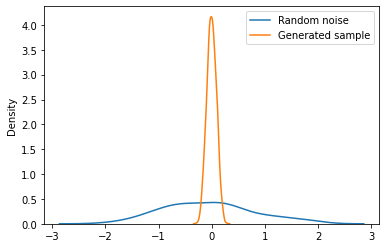

In [6]:
Z_DIM = 100
generator = make_generator_model(in_dim = Z_DIM, out_dim = M)
generator.summary()
# plot the model
plot_model(generator, show_shapes=True, show_layer_names=True)
noise = tf.random.normal([3, Z_DIM])
sns.kdeplot(noise[0,:], label = 'Random noise')
gen_X = generator(noise, training=False)
print(gen_X.shape)
sns.kdeplot(gen_X[0,:], label = 'Generated sample')
plt.legend()
plt.show()

### The moments and bincount

In [7]:
def m_bc(arr):
    #print(tf.nn.moments(arr,1))
    moments = tf.stack(tf.nn.moments(arr,1),axis=-1)
    int_arr = tf.cast(tf.math.rint(arr*100),'int32')
    tfbin = tf.math.bincount(int_arr,axis=-1)
    tfdiff = tf.stack(tf.nn.moments(tfbin,1),axis=-1)
    #print(moments)
    tfdiff = tf.cast(tfdiff,'float32')
    moments = tf.cast(moments,'float32')
    #print(moments.shape, tfdiff.shape)
    output = tf.concat([moments,tfdiff],axis=-1)
    return output
gen_moments = m_bc(gen_X)
gen_moments

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-4.5801583e-03,  7.9202550e-03,  2.3000000e+01,  1.1300000e+02],
       [-4.1208286e-03,  1.5202838e-02,  2.3000000e+01,  2.1000000e+02],
       [-1.3139870e-03,  3.9756484e-03,  1.2000000e+01,  4.4800000e+02]],
      dtype=float32)>

In [8]:
i =0
for batch in train_dataset:
    print(m_bc(batch))
    i+=1
    if i ==1: break

tf.Tensor(
[[ 0.49903977  0.08220519  9.         13.        ]
 [ 0.5004333   0.08370852  9.         12.        ]
 [ 0.51342225  0.08465424  9.         10.        ]
 [ 0.49726483  0.08282328  9.         10.        ]
 [ 0.5037136   0.08580691  9.         10.        ]
 [ 0.49605972  0.08051836  9.         11.        ]
 [ 0.4793845   0.08169593  9.          9.        ]
 [ 0.50253505  0.08571597  9.          9.        ]
 [ 0.5004914   0.08102649  9.         11.        ]
 [ 0.50314075  0.07997842  9.         12.        ]
 [ 0.514232    0.08116309  9.         10.        ]
 [ 0.49411356  0.08346911  9.         11.        ]
 [ 0.49250495  0.08280919  9.         11.        ]
 [ 0.5019324   0.08252537  9.         10.        ]
 [ 0.51261324  0.08081809  9.         11.        ]
 [ 0.48870385  0.08154596  9.         11.        ]
 [ 0.47629562  0.08321829  9.         10.        ]
 [ 0.501834    0.08419723  9.          9.        ]
 [ 0.49217355  0.08131916  9.         11.        ]
 [ 0.5031063   0.085

In [9]:
# check
[moment(gen_X[0],i) for i in range(1,5)]

[0.0, 0.007920255, -8.039692e-06, 0.0001674226]

In [10]:
MOMENT = 5

### The Discriminator

The discriminator is a CNN-based image classifier.

In [11]:
def make_discriminator_model(in_dim):
    model = tf.keras.Sequential()
    model.add(Dense(10, activation='relu', input_dim=in_dim))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    #model.add(layers.Dense(20, input_shape=(COL,)))
    #model.add(layers.LeakyReLU())
    model.add(Dense(1))
    model.add(LeakyReLU())
    return model

Use the (as yet untrained) discriminator to classify the generated samples as real or fake. The model will be trained to output positive values for real samples, and negative values for fake samples.

In [12]:
discriminator = make_discriminator_model(4)
discriminator.summary()
# plot the model
plot_model(discriminator, show_shapes=True, show_layer_names=True)
decision = discriminator(gen_moments)
print(decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1)                 0         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________
tf.Tensor(
[[10.333247]
 [18.166666]
 [36.92619 ]], shape=(3, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real samples from fakes. It compares the discriminator's predictions on real samples to an array of 1s, and the discriminator's predictions on fake (generated) samples to an array of 0s.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake samples as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


1. The training loop begins with generator receiving a random seed as input. That seed is used to produce a distribution. 
2. The discriminator is then used to classify real distributions (drawn from the training set) and fakes samples (produced by the generator). 
3. The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(samples):
    # 1.b. Get a new random noise vector z
    z = tf.random.normal([BATCH_SIZE, Z_DIM], mean=0, stddev=1.0)

    # Record gradients in tapes
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
    # 1.b. Using the Generator network to synthesize a batch of fake samples
        gen_X = generator(z, training=True)

    # 1.c. Use the discriminator to classify x and x*
        real_output = discriminator(m_bc(samples), training=True)
        fake_output = discriminator(m_bc(gen_X), training=True)

    # 1.d. Compute the classification error
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # 1.d.  Backpropagate the total error to update 
    #       both Generator and Discriminator's trainable parameters
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [19]:
def train(dataset, epochs, n_eval = 20):
    losses = []
    for epoch in range(epochs):
        start = time.time()

        for sample_batch in dataset:
            gl, dl = train_step(sample_batch)
            losses.append([gl,dl])
        # Save the model every n_eval epochs
        if (epoch + 1) % n_eval == 0:
                # Produce images for the GIF as we go
            display.clear_output(wait=True)
            gen_and_save_dist(generator, epoch + 1, seed)
            checkpoint.save(file_prefix = checkpoint_prefix)

            print ('Epoch {}:'.format(epoch + 1))
            print ('Execution time: {:.3f} sec'.format(time.time()-start))
            print ('Gen Loss and Dis Loss: {0:4.3f} and {1:4.3f} '.format(gl, dl))

    # Generate after the final epoch
    #display.clear_output(wait=True)
    #gen_and_save_dist(generator, epochs, seed)

    return losses

**Generate and save images**


In [20]:
def gen_and_save_dist(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(6,6))

    sns.kdeplot(predictions[0,:])
  
    plt.savefig('./Figs/Epoch #{0:04d}.png'.format(epoch))
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).


In [21]:
# Prepare the folder for figures
!rm -r Figs
!mkdir Figs

In [22]:
EPOCHS = 1000
N_EVAL = 5
Z_DIM = 100

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([1, Z_DIM])

In [ ]:
%%time
losses = train(train_dataset, EPOCHS,N_EVAL)

In [ ]:
losses = np.array(losses)
print(losses.shape)
plt.plot(losses[:,0],label = 'Generator Loss')
plt.plot(losses[:,1],label = 'Discriminator Loss')
plt.legend()
plt.savefig('Loss_log_ud2.png',dpi=200)
plt.show()

In [ ]:
files.download('Loss_log_ud3.png')

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# To generate GIFs
#!pip install imageio
!pip install git+https://github.com/tensorflow/docs
import glob
import imageio
import PIL

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('./Figs/Epoch #{0:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'vgan_ud3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('Figs/Epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
files.download(anim_file)

# END
